In [48]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from functools import wraps
import time
import math
import scipy
import os
import csv
import pandas as pd
import seaborn as sns

In [4]:
df = pd.DataFrame(columns=["time", "nodes", "edges", "best_w",  "iterations", "T0", "alpha"])

In [30]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result1, result2 = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start
        print(f"{func.__name__} took {elapsed:.6f} seconds")
        return (result1, result2, elapsed)
    return wrapper

In [6]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight = "weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight = "weight")
    best_w = best_tree.size(weight = "weight")
    best_nodes = set(best_tree.nodes())
    
    return best_tree, best_w, best_nodes

In [7]:
@timeit
def simulated_annealing(G, terminals, iterations, T0, alpha):
    current_tree, current_w, current_nodes = initialize(G, terminals)
    best_tree, best_w = current_tree, current_w
    nodes = list(set(G.nodes()) - set(terminals))
    T = T0

    for _ in range(iterations):
        v = random.choice(nodes)

        if random.random() < 0.5:
            candidate_nodes = current_nodes | {v}        
        else:
            candidate_nodes = (current_nodes - {v}) | set(terminals)
        
        subgraph = G.subgraph(candidate_nodes)
        
        if nx.is_connected(subgraph):
            new_tree = nx.minimum_spanning_tree(subgraph, weight = 'weight')
            new_w = new_tree.size(weight = 'weight')
            delta = new_w - current_w
            if delta < 0 or random.random() < math.exp(-delta / T):
                current_tree, current_w = new_tree, new_w
                current_nodes = set(new_tree.nodes())
                if current_w < best_w:
                    best_tree, best_w = current_tree, current_w
        T *= alpha

    return best_tree, best_w

In [8]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [9]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [10]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

simulated_annealing took 0.003562 seconds


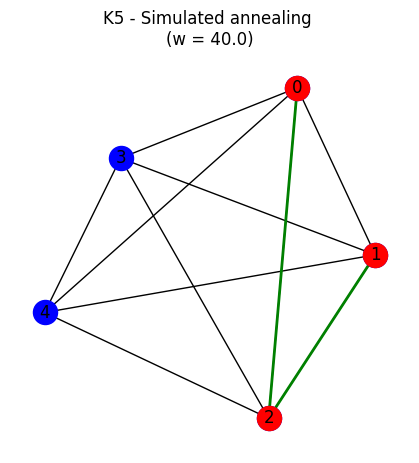

simulated_annealing took 0.001542 seconds


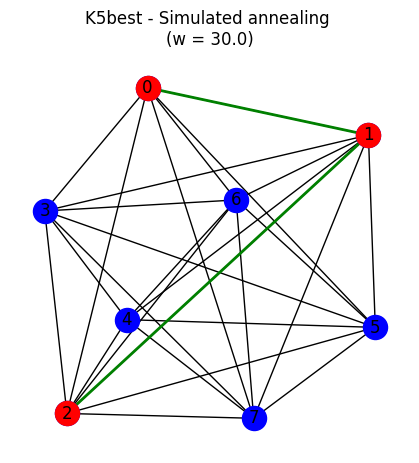

simulated_annealing took 0.001725 seconds


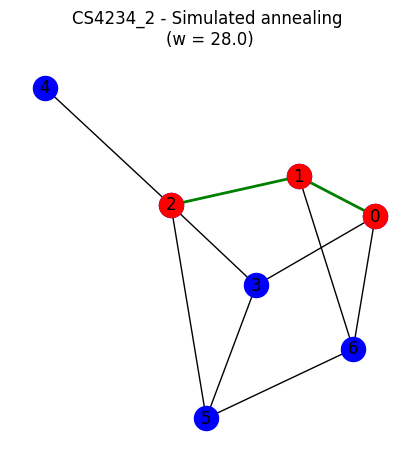

In [28]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w, _ = simulated_annealing(G, terminals, 10, 100, 0.95)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')

    plt.title(f"{name} - Simulated annealing \n(w = {w})")
    plt.show()

In [12]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [29]:
def tests(directory):
    global df
    df = df[0:0]
    results = {}
    
    for fname in os.listdir(directory):
        if fname.endswith(".stp"):
            path = os.path.join(directory, fname)
            try:
                G, terminals = read_stp(path) 
                results[fname] = (G, terminals)
                print(f"{fname} : (Number of nodes = {G.number_of_nodes()}, number of edges = {G.number_of_edges()}, number of terminals = {len(terminals)})")
                test_big(G, terminals)
            except Exception as e:
                print(f"File error {fname}: {e}")
        print("\n")
    return 

In [21]:
def test_big(G, terminals):
    global df
    num_iterations = [10,100,1000]
    T0s = [100,500, 1000]
    alphas = [0.90, 0.95, 0.99]
    for iterations in num_iterations:
        for T0 in T0s:
            for alpha in alphas:
                best_tree, best_w, elapsed = simulated_annealing(G, terminals, iterations, T0, alpha)
                new_row = {
                    "time": round(elapsed, 6),
                    "nodes" : G.number_of_nodes(),
                    "edges" : G.number_of_edges(),
                    "best_w": best_w,
                    "iterations": iterations,
                    "T0": T0,
                    "alpha": alpha
                }
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [37]:
tests('../Big graphs')
df.to_csv('results_sa.csv')
df

cc9-2u.stp : (Number of nodes = 512, number of edges = 2304, number of terminals = 64)
simulated_annealing took 2.404759 seconds
simulated_annealing took 2.402011 seconds
simulated_annealing took 2.392488 seconds
simulated_annealing took 2.399506 seconds
simulated_annealing took 2.368189 seconds
simulated_annealing took 2.417486 seconds
simulated_annealing took 2.407912 seconds
simulated_annealing took 2.434240 seconds
simulated_annealing took 2.413647 seconds
simulated_annealing took 3.496084 seconds
simulated_annealing took 3.504520 seconds
simulated_annealing took 3.480002 seconds
simulated_annealing took 3.401083 seconds
simulated_annealing took 3.517105 seconds
simulated_annealing took 3.460413 seconds
simulated_annealing took 3.466685 seconds
simulated_annealing took 3.393948 seconds
simulated_annealing took 3.586027 seconds
simulated_annealing took 10.047554 seconds
simulated_annealing took 10.349218 seconds
simulated_annealing took 10.860173 seconds
simulated_annealing took 9.6

,time,nodes,edges,best_w,iterations,T0,alpha
0,2.404759,512,2304,421.0,10,100,0.90
1,2.402011,512,2304,421.0,10,100,0.95
2,2.392488,512,2304,421.0,10,100,0.99
3,2.399506,512,2304,421.0,10,500,0.90
4,2.368189,512,2304,421.0,10,500,0.95
...,...,...,...,...,...,...,...
265,0.607542,64,192,34.0,1000,500,0.95
266,0.834002,64,192,36.0,1000,500,0.99
267,0.600058,64,192,35.0,1000,1000,0.90
268,0.612070,64,192,34.0,1000,1000,0.95


In [68]:
df = pd.read_csv('results_sa.csv')

In [35]:
df.to_csv('results_sa.csv')

In [38]:
sum(df["time"])

9449.057395000003

In [70]:
rows_per_graph = 27
df["graph_id"] = df.index // rows_per_graph + 1

In [71]:
graph_names = [ "cc9-2u", "hc6u", "hc7u", "hc9u", "cc3-5u", "hc8u", "cc5-3u", "cc6-3u", "hc10u", "cc6-2u"]
df["graph_name"] = df["graph_id"].map(lambda i: graph_names[i-1])

In [72]:
df

,Unnamed: 0,time,nodes,edges,best_w,iterations,T0,alpha,graph_id,graph_name
0,0,2.404759,512,2304,421.0,10,100,0.90,1,cc9-2u
1,1,2.402011,512,2304,421.0,10,100,0.95,1,cc9-2u
2,2,2.392488,512,2304,421.0,10,100,0.99,1,cc9-2u
3,3,2.399506,512,2304,421.0,10,500,0.90,1,cc9-2u
4,4,2.368189,512,2304,421.0,10,500,0.95,1,cc9-2u
...,...,...,...,...,...,...,...,...,...,...
265,265,0.607542,64,192,34.0,1000,500,0.95,10,cc6-2u
266,266,0.834002,64,192,36.0,1000,500,0.99,10,cc6-2u
267,267,0.600058,64,192,35.0,1000,1000,0.90,10,cc6-2u
268,268,0.612070,64,192,34.0,1000,1000,0.95,10,cc6-2u


In [47]:
grouped = df.groupby("graph_name").agg({
    "best_w": ["min", "max", "mean"],
    "time": ["mean", "max"]
})
print(grouped)

           best_w                            time            
              min     max        mean        mean         max
graph_name                                                   
cc3-5u       37.0    71.0   60.629630    0.504511    1.745369
cc5-3u       87.0   167.0  143.296296    1.352736    3.804518
cc6-2u       33.0    47.0   42.555556    0.279080    0.953643
cc6-3u      384.0   594.0  534.259259   10.634375   22.185604
cc9-2u      254.0   421.0  370.740741    5.367971   11.192808
hc10u       690.0  1020.0  903.000000  287.005116  308.329717
hc6u         39.0    62.0   47.740741    0.402279    1.025348
hc7u         77.0   124.0   99.518519    1.278961    2.667237
hc8u        154.0   252.0  207.703704    6.198080    9.324964
hc9u        311.0   507.0  430.259259   36.941980   45.597182


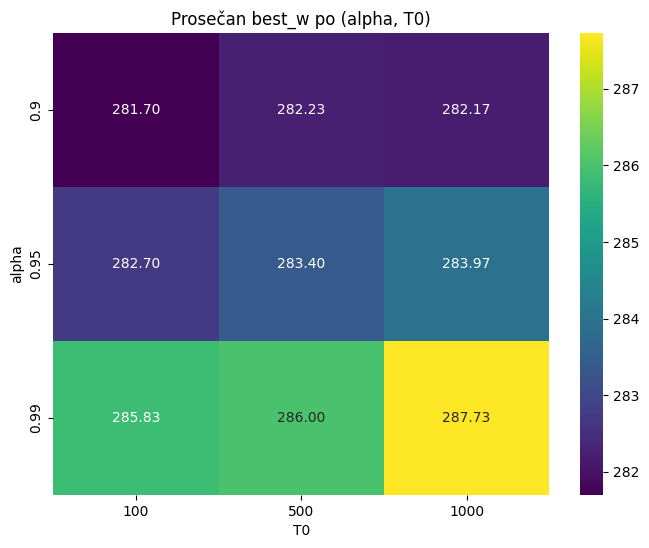

In [76]:
pivot = df.pivot_table(values = "best_w", index = "alpha", columns = "T0", aggfunc = "mean")

plt.figure(figsize = (8,6))
sns.heatmap(pivot, annot = True, fmt = ".2f", cmap = "viridis")
plt.title("Prosečan best_w po (alpha, T0)")
plt.show()

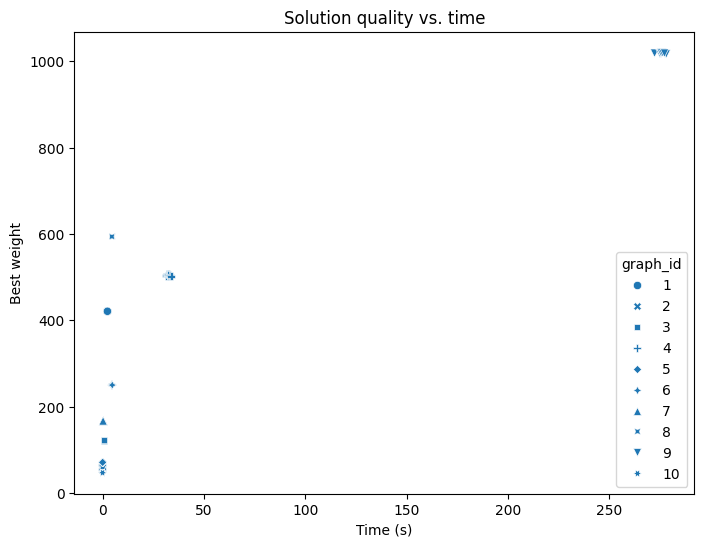

In [73]:
plt.figure(figsize = (8,6))
df1 = df[df["iterations"] == 10]
sns.scatterplot(data = df1, x = "time", y = "best_w", style = "graph_id")
plt.title("Solution quality vs. time")
plt.xlabel("Time (s)")
plt.ylabel("Best weight")
plt.show()


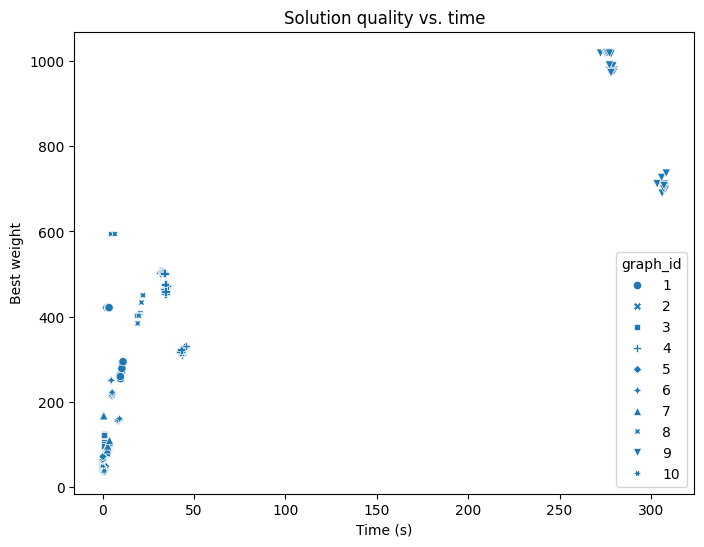

In [74]:
plt.figure(figsize = (8,6))
df2 = df[df["iterations"] == 100]
sns.scatterplot(data = df, x = "time", y = "best_w", style = "graph_id")
plt.title("Solution quality vs. time")
plt.xlabel("Time (s)")
plt.ylabel("Best weight")
plt.show()


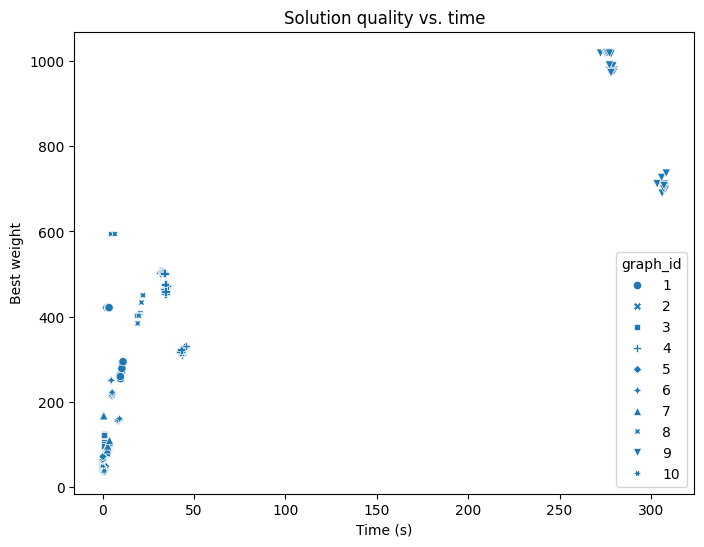

In [75]:
plt.figure(figsize = (8,6))
df3 = df[df["iterations"] == 1000]
sns.scatterplot(data = df, x = "time", y = "best_w", style = "graph_id")
plt.title("Solution quality vs. time")
plt.xlabel("Time (s)")
plt.ylabel("Best weight")
plt.show()


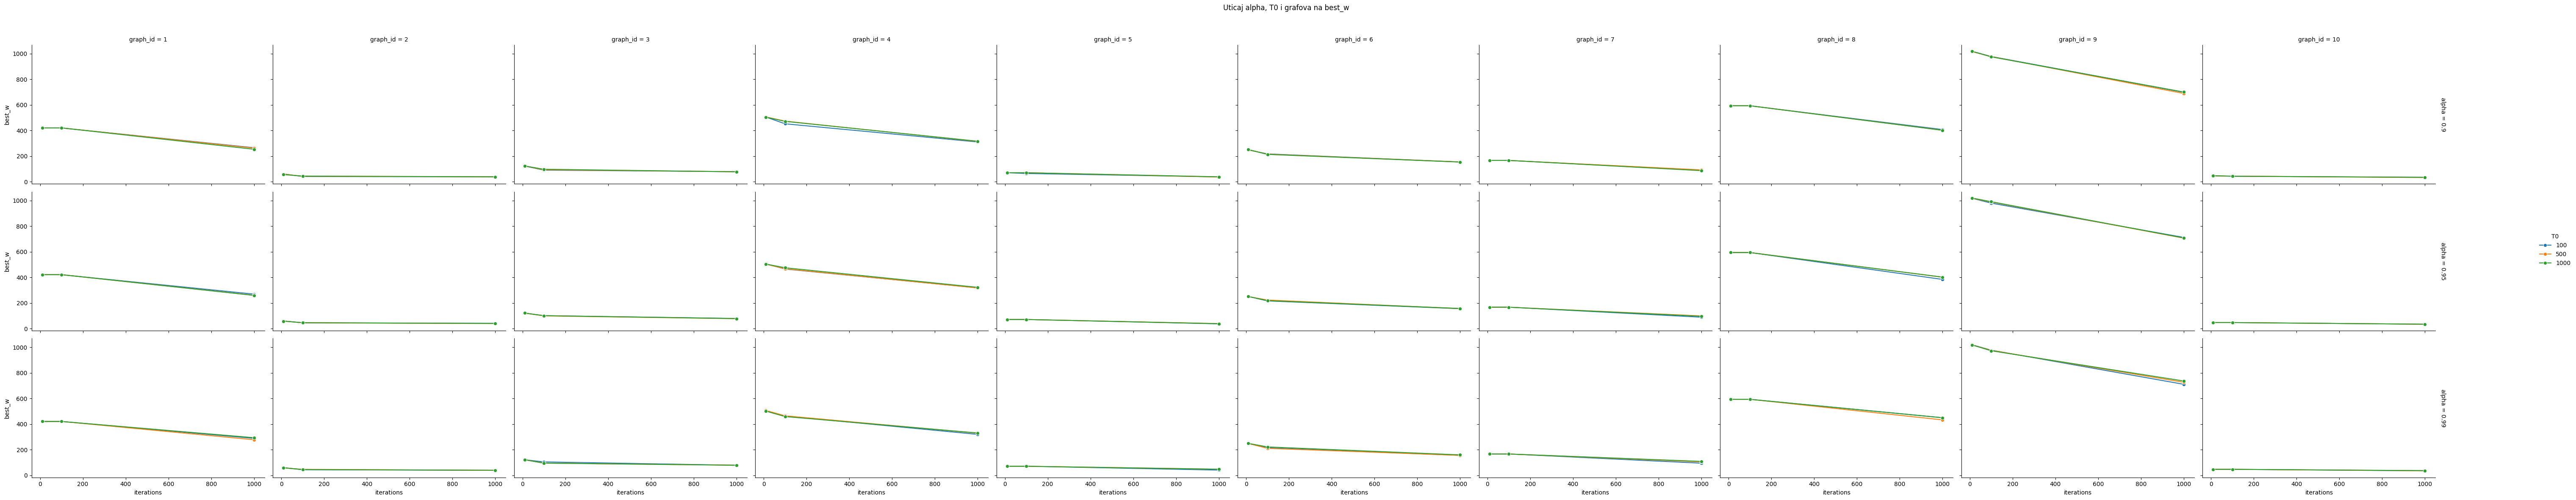

In [59]:
g = sns.FacetGrid(df, col = "graph_id", row = "alpha", hue = "T0", margin_titles = True, height = 4, aspect = 1.5)
g.map(sns.lineplot, "iterations", "best_w", marker = "o")
g.add_legend()
plt.subplots_adjust(top = 0.9)
g.fig.suptitle("Uticaj alpha, T0 i grafova na best_w")
plt.show()

In [49]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals)
    
plt.figure(figsize = (4,4))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()

TypeError: simulated_annealing() missing 3 required positional arguments: 'iterations', 'T0', and 'alpha'

simulated_annealing took 0.224647 seconds


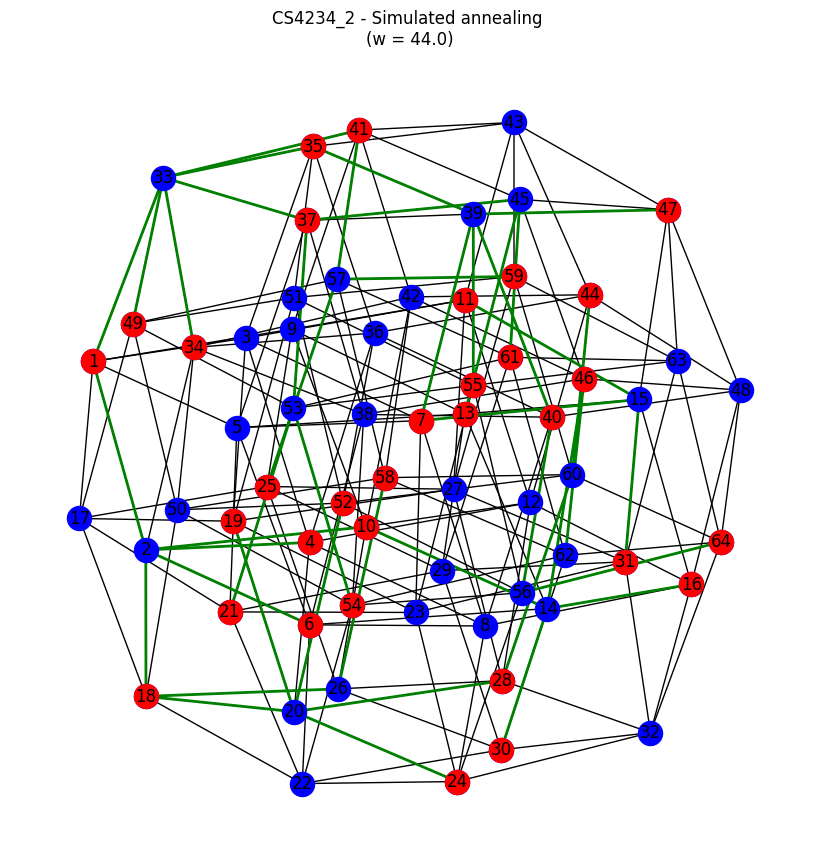

In [145]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 100)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
 
plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze

simulated_annealing took 0.963525 seconds


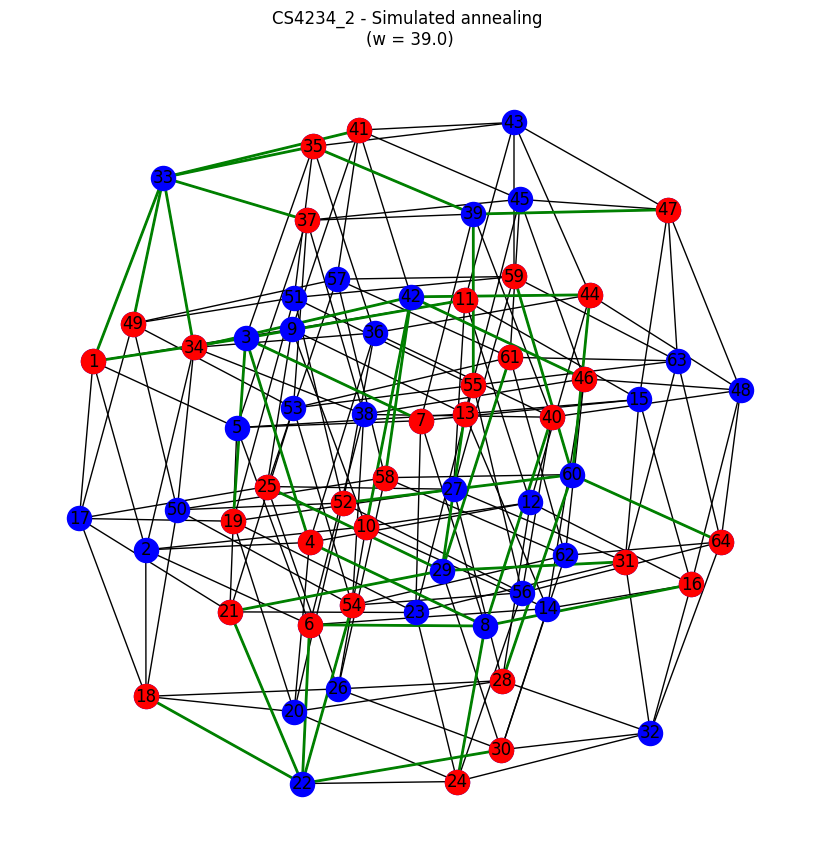

In [98]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 1000)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze

simulated_annealing took 7.349089 seconds


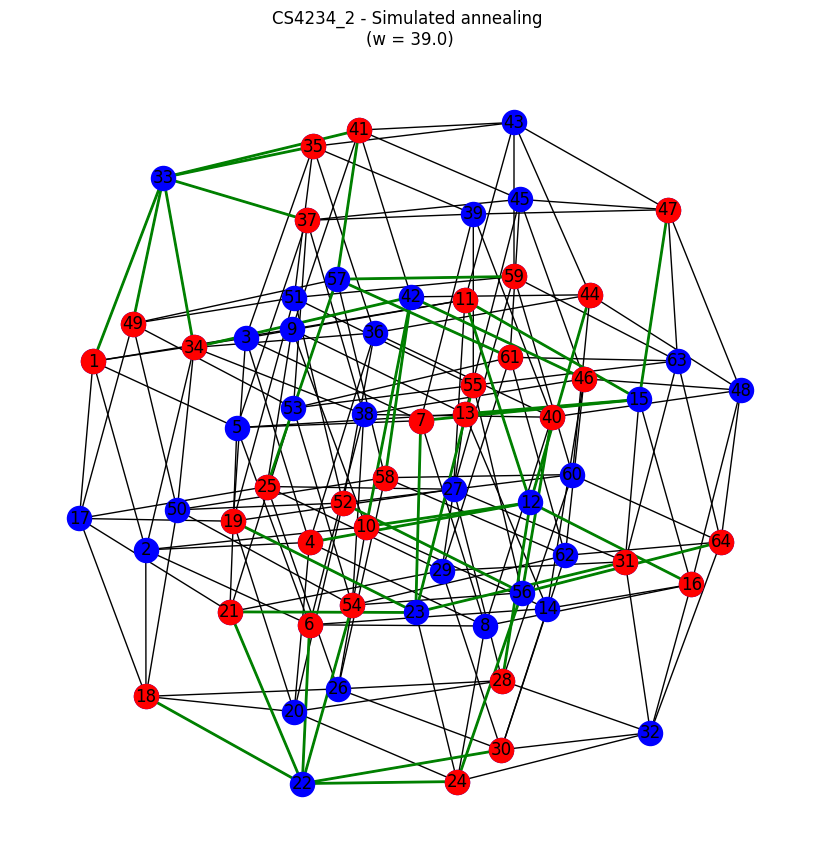

In [99]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 10000)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze